In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import Dataset, DatasetDict

In [40]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [41]:
df = pd.read_csv('/kaggle/input/tm-dataset/output.csv')

# EDA

In [42]:
df.head()

,id,app_id,content,author_id,is_positive
0,181331361,100,At least its a counter strike -1/100,76561199556485100,Negative
1,180872601,100,Uh... So far my playthrough has not been great...,76561199230620391,Negative
2,177836246,100,Better mechanics than cs2,76561198417690647,Negative
3,177287444,100,buggy mess and NOT fun to play at all,76561199077268730,Negative
4,176678990,100,"Whoever came up with this, is gonna fucking ge...",76561199104544266,Negative


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201151 entries, 0 to 201150
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           201151 non-null  int64 
 1   app_id       201151 non-null  int64 
 2   content      200723 non-null  object
 3   author_id    201151 non-null  int64 
 4   is_positive  201151 non-null  object
dtypes: int64(3), object(2)
memory usage: 7.7+ MB


## Check Missing Value

In [44]:
df.isnull().sum()

id               0
app_id           0
content        428
author_id        0
is_positive      0
dtype: int64

Ditemukan terdapat beberapa data review yang null value

## Check Duplicate Data

In [45]:
df.duplicated().sum()

0

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201151 entries, 0 to 201150
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           201151 non-null  int64 
 1   app_id       201151 non-null  int64 
 2   content      200723 non-null  object
 3   author_id    201151 non-null  int64 
 4   is_positive  201151 non-null  object
dtypes: int64(3), object(2)
memory usage: 7.7+ MB


Ditemukan bahwa tidak terdapat duplicate data di dataset yang digunakan

## Sentiment Proportion

In [47]:
df['is_positive'].value_counts()

is_positive
Positive    102660
Negative     98491
Name: count, dtype: int64

<Axes: xlabel='is_positive', ylabel='count'>

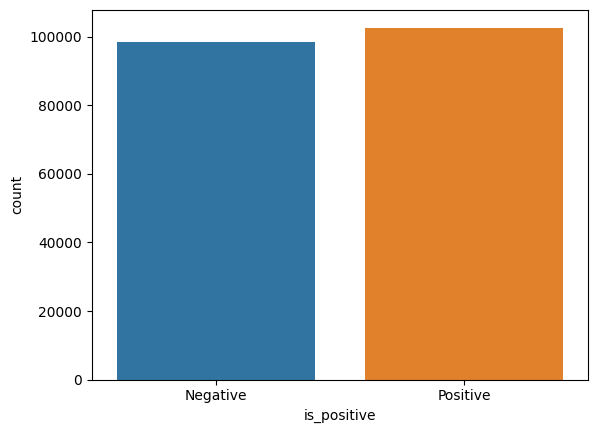

In [48]:
sns.countplot(x = 'is_positive', data= df)

Dari plot di atas dapat dilihat bahwa distribusi sentimen (positif dan negatif) seimbang dimana jumlah data dengan sentimen positif sebanyak 102.377 dan dengan sentimen negatif sebanyak 98.346

## Review Length Distribution

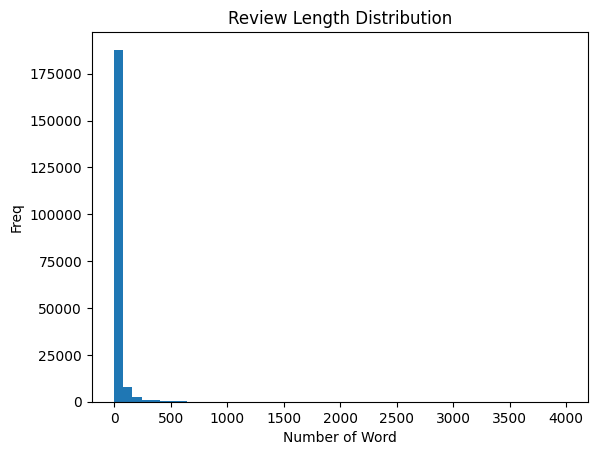

Review Average Length: 25.232203667891287
Review Median Length: 8.0


In [49]:
df['content_len'] = df['content'].apply(lambda x: len(str(x).split()))

plt.hist(df['content_len'], bins=50)
plt.title("Review Length Distribution")
plt.xlabel("Number of Word")
plt.ylabel("Freq")
plt.show()

print("Review Average Length:", df['content_len'].mean())
print("Review Median Length:", df['content_len'].median())

Dari plot di atas ditemukan bahwa rata - rata panjang review sebesar 25.28 kata dimana menunjukkan bahwa teks review yang diberikan oleh pengguna memiliki panjang yang sedang, tidak terlalu panjang maupun pendek

## Vocalbulary Size

In [50]:
all_words = " ".join(df['content'].astype(str)).split()
vocab = set(all_words)
print("Number of Words:", len(all_words))
print("Unique Words:", len(vocab))

Number of Words: 5075483
Unique Words: 225636


Dapat dilihat bahwa jumlah kata di keseluruhan data berjumlah sekitar 5 juta kata dengan 225 ribu unik kata

## Check Noise

In [51]:
df_filtered = df[df['content'].str.contains('https', case=False, na=False)]

In [52]:
df_filtered.head()

,id,app_id,content,author_id,is_positive,content_len
106,71241342,100,[h1] Counter-Strike: Condition Zero Deleted Sc...,76561198368099358,Negative,309
164,136674606,630,Alien Swarm: Reactive Drop is basically the sa...,76561198427365449,Negative,13
609,8063356,630,"Well, assuming that you like these overhead sh...",76561198022595876,Negative,57
826,109950768,20,[h1] Team Fortress Classic [/h1]\n\n[b] A Clas...,76561198368099358,Negative,204
832,107086345,20,Here you will see why I love Team Fortress Cla...,76561198437967307,Negative,274


In [53]:
slang_ex = 'lol|gg|lmao'
df_filtered2 = df[df['content'].str.contains(slang_ex, case=False, na=False)]
df_filtered2.head()

,id,app_id,content,author_id,is_positive,content_len
3,177287444,100,buggy mess and NOT fun to play at all,76561199077268730,Negative,9
15,161782841,100,"𝗩𝗮𝗹𝘃𝗲'𝘀 ""𝗗𝗲𝘀𝘁𝗶𝗻𝗲𝗱 𝘁𝗼 𝗯𝗲 𝗮 𝗳𝗮𝗶𝗹𝘂𝗿𝗲"" 𝗰𝗵𝗶𝗹𝗱\r\n\r...",76561198966155773,Negative,354
36,143548889,100,"even on easy, the last couple missions are exh...",76561198052362550,Negative,18
62,121481953,100,brony easter egg. do not purchase.,76561198069815091,Negative,6
140,161357435,630,negga negga neggga neggga i am 100 % a negga,76561199633393920,Negative,10


Di sini kami melakukan pengecekan terhadap noise (data kotor) di text review. Di sini ditemukan bahwa terdapat noise berupa link URL dan in-game slang

## Top Words in Each Sentiment

In [54]:
from nltk.tokenize import word_tokenize
from collections import Counter
from nltk.stem import WordNetLemmatizer

In [55]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
df_temp = df.dropna()
reviews = df_temp['content']
stop_words = set(stopwords.words('english'))
lem = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [56]:
slangs = {
    "lol": "laughing",
    "lmao": "laughing",
    "wtf": "what the fuck",
    "idk": "i dont know",
    "gg": "good game"
}


In [57]:
def normalize_slang(text):
    words = text.split()
    normalized = [slangs.get(w, w) for w in words]
    return " ".join(normalized)

In [58]:
clean_reviews = []
for text in reviews :
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', r'', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\d+', '', text)
    text = normalize_slang(text)
    clean_reviews.append(text)

In [59]:
df_temp['clean_text'] = clean_reviews

/tmp/ipykernel_161/394526619.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['clean_text'] = clean_reviews


In [60]:
df_temp.head()

,id,app_id,content,author_id,is_positive,content_len,clean_text
0,181331361,100,At least its a counter strike -1/100,76561199556485100,Negative,7,at least its a counter strike
1,180872601,100,Uh... So far my playthrough has not been great...,76561199230620391,Negative,42,uh so far my playthrough has not been great gl...
2,177836246,100,Better mechanics than cs2,76561198417690647,Negative,4,better mechanics than cs
3,177287444,100,buggy mess and NOT fun to play at all,76561199077268730,Negative,9,buggy mess and not fun to play at all
4,176678990,100,"Whoever came up with this, is gonna fucking ge...",76561199104544266,Negative,14,whoever came up with this is gonna fucking get...


In [61]:
df_temp['cleaned_token'] = df_temp['clean_text'].apply(lambda x : word_tokenize(x))
df_temp['cleaned_token'] = df_temp['cleaned_token'].apply(lambda tokens: [t for t in tokens if t not in stop_words])
df_temp['cleaned_token'] = df_temp['cleaned_token'].apply(lambda tokens :[lem.lemmatize(t) for t in tokens])

/tmp/ipykernel_161/2340858172.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cleaned_token'] = df_temp['clean_text'].apply(lambda x : word_tokenize(x))
/tmp/ipykernel_161/2340858172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['cleaned_token'] = df_temp['cleaned_token'].apply(lambda tokens: [t for t in tokens if t not in stop_words])
/tmp/ipykernel_161/2340858172.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

In [62]:
custom_stopwords = ['game', 'play']

In [63]:
for score in sorted(df_temp['is_positive'].unique()) :
    tokens = [token for tokens_list in df_temp[df_temp['is_positive'] == score]['cleaned_token'] for token in tokens_list]
    freq = Counter(tokens)

    print(f'Top 10 Words (Score {score})')
    for word, count in freq.most_common(12):
        if word not in custom_stopwords:
            print(word, ":", count)
    print('\n')

Top 10 Words (Score Negative)
valve : 15158
bot : 14760
dont : 13042
like : 12983
get : 12330
time : 11344
even : 9146
good : 9046
fix : 8990
player : 8845


Top 10 Words (Score Positive)
good : 18929
fun : 14463
like : 10533
still : 8523
one : 8474
great : 7946
best : 7748
halflife : 7597
time : 7383
life : 7299




Di sini ditunjukkan 10 kata teratas untuk masing masing sentiment dimana, untuk sentimen positif memiliki top words bernada positif berupa fun, great best. Sedangkan untuk sentimen negatif memiliki top words bernada negatif seperti fix, bot dan valve.

# Preprocessing

## Handle Missing Values

In [64]:
df.dropna(inplace = True)

In [65]:
df.isnull().sum()

id             0
app_id         0
content        0
author_id      0
is_positive    0
content_len    0
dtype: int64

Di sini kami melakukan penghapusan data dengan missing value

## Split Data

In [66]:
x = df['content']
y = df['is_positive']

In [67]:
stop_word = set(stopwords.words('english'))
x_clean_tf = []
for text in x :
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', r'', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'\d+', '', text)
    text = normalize_slang(text)

    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stop_word and len(w) > 1]
    x_clean_tf.append(" ".join(tokens))

Di sini dilakuan pembagian data x dan y. Selain itu data x di bersihkan untuk perisapan modeling

## Split Train Test Data - TFIDF


In [68]:
x_train_tf, x_test_tf, y_train_tf, y_test_tf = train_test_split(x_clean_tf, y, test_size = 0.2, random_state = 42, stratify = y)

In [69]:
print(len(x_train_tf))
print(len(x_test_tf))

160578
40145


## Text Representation - TF-IDF

In [70]:
tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2))
x_train_tfidf = tfidf.fit_transform(x_train_tf)
x_test_tfidf = tfidf.transform(x_test_tf)

In [71]:
print("TF-IDF")
print("Shape (train):", x_train_tfidf.shape)
print("Jumlah vocab:", len(tfidf.vocabulary_))
print("Beberapa vocab:", list(tfidf.vocabulary_.keys())[:20])

TF-IDF
Shape (train): (160578, 30000)
Jumlah vocab: 30000
Beberapa vocab: ['game', 'wouldnt', 'get', 'wont', 'even', 'play', 'actual', 'start', 'steam', 'dont', 'waste', 'money', 'wouldnt get', 'get game', 'game wont', 'wont even', 'even play', 'play actual', 'actual game', 'game even']


# Modeling

## Multinominal Naive Bayes

In [72]:
nb = MultinomialNB()
nb.fit(x_train_tfidf, y_train_tf)

MultinomialNB()

In [73]:
pred_nb = nb.predict(x_test_tfidf)
print(classification_report(y_test_tf, pred_nb))

              precision    recall  f1-score   support

    Negative       0.85      0.79      0.82     19669
    Positive       0.81      0.87      0.84     20476

    accuracy                           0.83     40145
   macro avg       0.83      0.83      0.83     40145
weighted avg       0.83      0.83      0.83     40145



## SVM

In [74]:
from sklearn.svm import LinearSVC

In [75]:
svm = LinearSVC()

In [76]:
svm.fit(x_train_tfidf, y_train_tf)

LinearSVC()

In [77]:
pred_svm = svm.predict(x_test_tfidf)

print(classification_report(y_test_tf, pred_svm))

              precision    recall  f1-score   support

    Negative       0.86      0.80      0.83     19669
    Positive       0.82      0.88      0.85     20476

    accuracy                           0.84     40145
   macro avg       0.84      0.84      0.84     40145
weighted avg       0.84      0.84      0.84     40145



### Words Weight

In [78]:
feature_names = tfidf.get_feature_names_out()
coef = svm.coef_[0]

In [79]:
top_pos_idx = np.argsort(coef)[-10:]
top_pos_words = feature_names[top_pos_idx]

top_neg_idx = np.argsort(coef)[:10]
top_neg_words = feature_names[top_neg_idx]

In [80]:
print("Top Positive:\n", top_pos_words)
print("\nTop Negative:\n", top_neg_words)

Top Positive:
 ['bad thing' 'better cs' 'diamond' 'well worth' 'get used' 'better tf'
 'never gets' 'classic' 'dont regret' 'underrated']

Top Negative:
 ['fixtf' 'dota' 'savetf' 'unplayable' 'boring' 'cant recommend' 'age well'
 'moba' 'dont recommend' 'unless']


## DistilBERT

In [81]:
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"


In [82]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify = y, random_state=42)

In [83]:
len(y_train)

160578

In [84]:
label_map = {'Negative': 0, 'Positive': 1}

train_df = pd.DataFrame({"text": x_train, "label": y_train.map(label_map)})
test_df = pd.DataFrame({"text": x_test, "label": y_test.map(label_map)})

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "test": Dataset.from_pandas(test_df)
})


In [85]:
distilbert = "distilbert-base-uncased"
tokenizer_distilbert = AutoTokenizer.from_pretrained(distilbert)
model_distilbert = AutoModelForSequenceClassification.from_pretrained(distilbert, num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [86]:
def tokenize_function(batch):
       return tokenizer_distilbert(batch["text"], padding="max_length", truncation=True, max_length=256)

In [87]:
tokenized_datasets_distilbert = dataset.map(tokenize_function, batched=True)

tokenized_datasets_distilbert = tokenized_datasets_distilbert.remove_columns(["text"])
tokenized_datasets_distilbert = tokenized_datasets_distilbert.rename_column("label", "labels")
tokenized_datasets_distilbert.set_format("torch")

train_dataset_distilbert = tokenized_datasets_distilbert["train"]
test_dataset_distilbert = tokenized_datasets_distilbert["test"]

Map:   0%|          | 0/160578 [00:00<?, ? examples/s]

Map:   0%|          | 0/40145 [00:00<?, ? examples/s]

In [88]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        'accuracy': accuracy_score(p.label_ids, preds),
        'f1': f1_score(p.label_ids, preds, average='binary')
    }

In [89]:
training_args = TrainingArguments(
    output_dir="./distilbert_output",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate = 2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./steam_sentiment_logs',
    logging_steps=500,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model_distilbert,
    args=training_args,
    train_dataset=train_dataset_distilbert,
    eval_dataset=test_dataset_distilbert,
    compute_metrics=compute_metrics
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [90]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.285400,0.284192,0.878241,0.880920
2,0.224300,0.274245,0.886736,0.888959
3,0.175800,0.306820,0.888081,0.891555


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=15057, training_loss=0.24496400404587648, metrics={'train_runtime': 6792.3082, 'train_samples_per_second': 70.923, 'train_steps_per_second': 2.217, 'total_flos': 3.190702491207475e+16, 'train_loss': 0.24496400404587648, 'epoch': 3.0})

In [91]:
evaluation_results = trainer.evaluate()
print(evaluation_results)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.2742445170879364, 'eval_accuracy': 0.8867355835097771, 'eval_f1': 0.8889594373488974, 'eval_runtime': 173.7073, 'eval_samples_per_second': 231.107, 'eval_steps_per_second': 7.225, 'epoch': 3.0}


In [92]:
pred = trainer.predict(test_dataset_distilbert)
pred_label = pred.predictions.argmax(axis=1)

label_map = {'Negative': 0, 'Positive': 1}
y_test_numeric = y_test.map(label_map)

print(classification_report(y_test_numeric, pred_label))

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.88      0.88      0.88     19669
           1       0.89      0.89      0.89     20476

    accuracy                           0.89     40145
   macro avg       0.89      0.89      0.89     40145
weighted avg       0.89      0.89      0.89     40145



## BERT

In [93]:
bert = "bert-base-uncased"
tokenizer_bert = BertTokenizer.from_pretrained(bert)
model_bert = BertForSequenceClassification.from_pretrained(bert, num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [94]:
def tokenizeBert(batch):
    return tokenizer_bert(batch["text"], padding="max_length", truncation=True,max_length=256)

In [95]:
tokenized_datasets_bert = dataset.map(tokenizeBert, batched=True)
tokenized_datasets_bert = tokenized_datasets_bert.remove_columns(["text"])
tokenized_datasets_bert = tokenized_datasets_bert.rename_column("label", "labels")
tokenized_datasets_bert.set_format("torch")

train_dataset_bert = tokenized_datasets_bert["train"]
test_dataset_bert = tokenized_datasets_bert["test"]

Map:   0%|          | 0/160578 [00:00<?, ? examples/s]

Map:   0%|          | 0/40145 [00:00<?, ? examples/s]

In [97]:
training_args2 = TrainingArguments(
    output_dir="./bert-output",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_steps=500,
    report_to="none",
    label_names=["labels"],
    num_train_epochs=3,
    learning_rate = 2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./steam_sentiment_logs',
    load_best_model_at_end=True
)

trainer2 = Trainer(
    model=model_bert,
    args=training_args2,
    train_dataset=train_dataset_bert,
    eval_dataset=test_dataset_bert,
    compute_metrics = compute_metrics
)

In [98]:
trainer2.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.276500,0.269148,0.884967,0.887470
2,0.210000,0.273854,0.889775,0.892406
3,0.153200,0.318619,0.890796,0.893901


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=15057, training_loss=0.2326597584396781, metrics={'train_runtime': 13334.4817, 'train_samples_per_second': 36.127, 'train_steps_per_second': 1.129, 'total_flos': 6.337477057139712e+16, 'train_loss': 0.2326597584396781, 'epoch': 3.0})

In [99]:
pred_bert = trainer2.predict(test_dataset_bert)


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [100]:
pred_label_bert = pred_bert.predictions.argmax(axis=1)

In [101]:
pred_label_bert


array([1, 1, 1, ..., 1, 0, 0])

In [102]:
y_test_numeric2 = y_test.map(label_map)

print(classification_report(y_test_numeric2, pred_label_bert))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     19669
           1       0.89      0.89      0.89     20476

    accuracy                           0.88     40145
   macro avg       0.88      0.88      0.88     40145
weighted avg       0.88      0.88      0.88     40145



In [103]:
from sklearn.metrics import accuracy_score

In [104]:
print('BERT Model',accuracy_score(y_test_numeric2, pred_label_bert))
print('DistilBERT Model', accuracy_score(y_test_numeric, pred_label))
print('SVM Model', accuracy_score(y_test_tf, pred_svm))
print('Naive Bayes Model', accuracy_score(y_test_tf, pred_nb))

BERT Model 0.884966994644414
DistilBERT Model 0.8867355835097771
SVM Model 0.836617262423714
Naive Bayes Model 0.8294432681529456


Dari hasil keselurah model, dapat disimpulkan bahwa model DistilBERT merupakan model dengan performa terbaik dengan akurasi sebesar 0.886 yang menunjukkan betapa pentingnya representasi semantik (pengertian konteks) dalam melakukan sentimen analisis untuk review game